In [1]:
from pathlib import Path
import os, sys

HERE = Path.cwd().resolve()

PROJECT_ROOT = None
for parent in [HERE] + list(HERE.parents):
    if (parent / "pyproject.toml").exists() or (parent / "src" / "digital_twin").exists():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError("Could not locate project root")

SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

os.chdir(SRC_PATH)

In [28]:
# Optional: install this package
# Uncomment the line below if digital_twin is not installed
# !pip install git+https://github.com/KaizarAnalytics/digital_twin.git

# **2. The Proof of Concept**

This section demonstrates a lightweight forecasting experiment designed to test whether historical arrival patterns contain usable predictive signals. The aim is **not** to build a production-ready model, but to explore whether a simple machine-learning approach can complement the simulation engine.


In [2]:
import pandas as pd
from digital_twin.hospital.data_prep import load_patients, arrivals_per_day
from digital_twin.hospital.config_loader import load_hospital_config
from digital_twin.core.arrivals_ml import make_feature_table, train_lgbm_poisson, predict_mean, rolling_backtest

import matplotlib.pyplot as plt
import matplotlib as mpl

config = load_hospital_config("digital_twin/hospital/configs/hospital_1.yml").simulation

try:
    mpl.style.use("kaizar")
except OSError:
    mpl.style.use("default")
%matplotlib inline



# 1. Data
patients = load_patients(config['data_dir'])
arr = arrivals_per_day(patients, config['service_default'])["arrivals"]

arr.head(), arr.describe()


(arrival_day
 2025-01-03    1
 2025-01-04    1
 2025-01-05    0
 2025-01-06    2
 2025-01-07    1
 Freq: D, Name: arrivals, dtype: int64,
 count    363.000000
 mean       0.699725
 std        0.807886
 min        0.000000
 25%        0.000000
 50%        1.000000
 75%        1.000000
 max        4.000000
 Name: arrivals, dtype: float64)

Here, we train a **LightGBM model** using a **Poisson objective**, suitable for count-based arrival data. The model operates purely on historic patterns, without calendar effects, domain-specific features, or operational metadata—those elements are part of the commercial stack and are intentionally excluded from this public showcase.


In [3]:
from digital_twin.core.arrivals_ml import make_feature_table, train_lgbm_poisson, predict_mean

df_feat = make_feature_table(arr)
model, cv_stats = train_lgbm_poisson(df_feat)

cv_stats


{'mae_mean': 0.8937230265143622, 'mae_std': 0.4333268833240811}

Next, we rebuild the LightGBM model alongside a **naive forecasting baseline** to compare signal strength. The idea is straightforward: if the model outperforms naive persistence on short-horizon predictions, it suggests that the arrival process contains structure worth exploiting.

In a full implementation, this forecast would serve as one of the drivers for scenario generation: a forward-looking estimate of where peak pressure may arise, treated as a probabilistic input to the simulation.


In [4]:
from digital_twin.core.arrivals_ml import rolling_backtest

bt = rolling_backtest(arr, horizon=28, min_history=180, step=7)
bt.mae_model, bt.mae_seasonal_naive, bt.coverage_80


(0.6687941043730667, 0.6816770186335404, 0.9270186335403726)

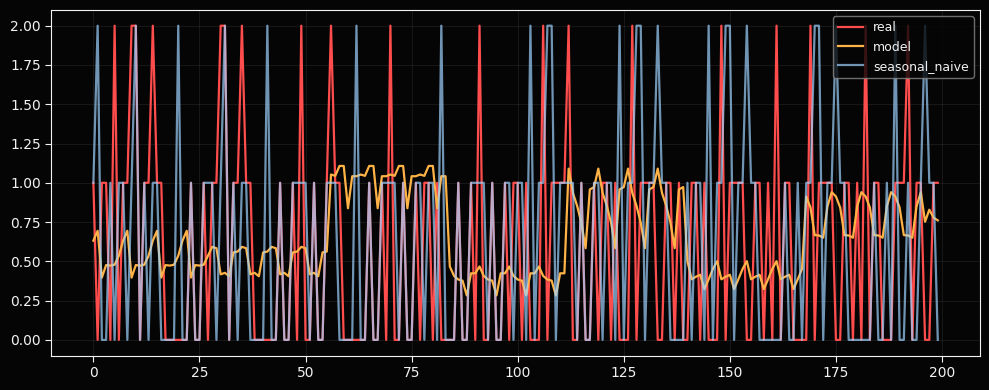

In [5]:
d = bt.details
plt.figure(figsize=(10,4))
plt.plot(d["real"][:200], label="real")
plt.plot(d["pred"][:200], label="model")
plt.plot(d["naive"][:200], label="seasonal_naive", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


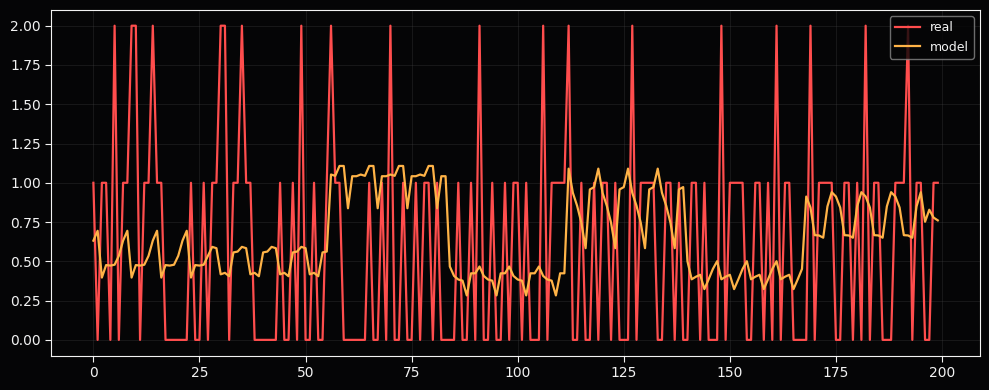

In [6]:
plt.figure(figsize=(10,4))
plt.plot(d["real"][:200], label="real")
plt.plot(d["pred"][:200], label="model")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
from digital_twin.core.arrivals_ml import forecast_mu_forward

mu_fc = forecast_mu_forward(arr, horizon=180)
mu_fc.head(), mu_fc.tail()


(2026-01-01    0.579112
 2026-01-02    0.858642
 2026-01-03    0.910701
 2026-01-04    0.859246
 2026-01-05    0.478179
 Freq: D, Name: mu, dtype: float64,
 2026-06-25    0.606898
 2026-06-26    0.655847
 2026-06-27    0.705006
 2026-06-28    0.413709
 2026-06-29    0.598340
 Freq: D, Name: mu, dtype: float64)

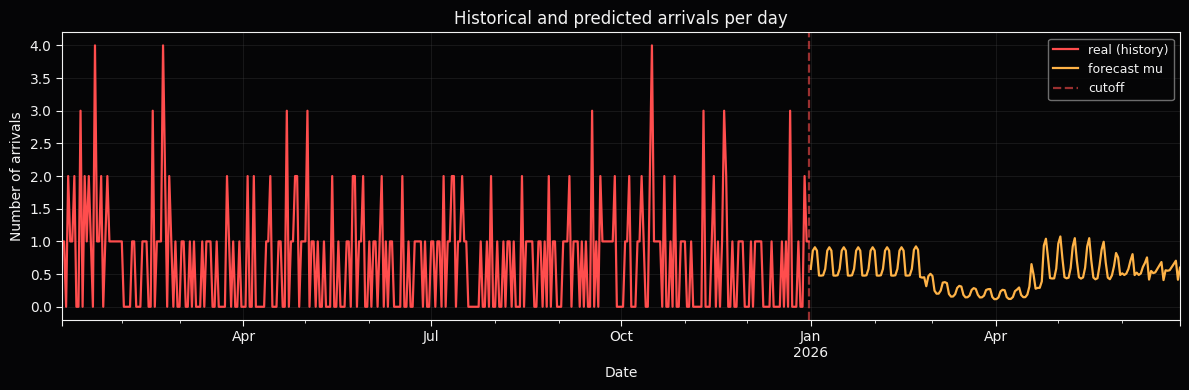

In [8]:
import matplotlib.pyplot as plt

hist = arr

fig, ax = plt.subplots(figsize=(12,4))

hist.plot(ax=ax, label="real (history)")
mu_fc.plot(ax=ax, label="forecast mu")

ax.axvline(hist.index.max(), linestyle="--", alpha=0.6, label="cutoff")

ax.set_title("Historical and predicted arrivals per day")
ax.set_ylabel("Number of arrivals")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()


In [9]:
from digital_twin.hospital.data_prep import los_values
from digital_twin.hospital.config_loader import load_hospital_config
config = load_hospital_config("digital_twin/hospital/configs/hospital_1.yml").simulation
from digital_twin.core.mc_simulator import simulate_from_mu_series
from digital_twin.output.metrics import risk_summary
import numpy as np
seed=42
rng = np.random.default_rng(seed)

los = los_values(patients, config['service_default'])
los_sampler = lambda n: rng.choice(los, size=n, replace=True)

max_occ_ml, od_ml = simulate_from_mu_series(
    mu_series=mu_fc,
    n_runs=3000,
    beds=config['capacity_default'],
    processtime_sampler=los_sampler,
)

risk_summary(max_occ_ml, od_ml, config['capacity_default'])


{'P(max>100%)': 0.0,
 'P(max>95%)': 0.0,
 'mean_overflow_days': 0.0,
 'p95_max_occ': 13.0,
 'median_max_occ': 10.0}

In [10]:
from digital_twin.core.mc_simulator import make_arrival_sampler, simulate_occupancy
from digital_twin.hospital.data_prep import arrivals_per_day

arr_df = arrivals_per_day(patients, config['service_default'])
arr = arr_df["arrivals"]
arrival_sampler_hist = make_arrival_sampler(arr)

max_occ_hist, od_hist = simulate_occupancy(
    days=len(mu_fc),
    n_runs=3000,
    beds=config['capacity_default'],
    arrival_sampler=lambda size: arrival_sampler_hist(size=size),
    processtime_sampler=los_sampler,
)

print("Hist bootstrap:", risk_summary(max_occ_hist, od_hist, config['capacity_default']))
print("ML+Poisson   :", risk_summary(max_occ_ml, od_ml, config['capacity_default']))


Hist bootstrap: {'P(max>100%)': 0.0, 'P(max>95%)': 0.0, 'mean_overflow_days': 0.0, 'p95_max_occ': 14.0, 'median_max_occ': 11.0}
ML+Poisson   : {'P(max>100%)': 0.0, 'P(max>95%)': 0.0, 'mean_overflow_days': 0.0, 'p95_max_occ': 13.0, 'median_max_occ': 10.0}


In [11]:
from digital_twin.core.mc_simulator import beds_vs_risk_from_mu
bed_grid = range(8, 21)
df_curve_ml = beds_vs_risk_from_mu(mu_fc, bed_grid, n_runs=3000, processtime_sampler=los_sampler)


In [12]:
from digital_twin.core.mc_simulator import beds_vs_risk_from_mu
from digital_twin.hospital.data_prep import los_values

from digital_twin.hospital.config_loader import load_hospital_config
config = load_hospital_config("digital_twin/hospital/configs/hospital_1.yml").simulation

los = los_values(patients, config['service_default'])
los_sampler = lambda n: rng.choice(los, size=n, replace=True)

bed_grid = range(8, 21)

df_curve_ml = beds_vs_risk_from_mu(
    mu_series=mu_fc,
    bed_values=bed_grid,
    n_runs=3000,
    processtime_sampler=los_sampler,
)

df_curve_ml


,beds,P(max>100%),P(max>95%),p95_max_occ,mean_overflow_days
0,8,0.902000,0.985667,13.0,7.923000
1,9,0.724333,0.906333,13.0,3.936333
2,10,0.467333,0.714000,13.0,1.728333
3,11,0.241667,0.464000,13.0,0.660667
4,12,0.112333,0.240333,13.0,0.264000
5,13,0.037333,0.109333,13.0,0.076333
6,14,0.022000,0.053333,14.0,0.041667
7,15,0.004333,0.015000,13.0,0.007333
8,16,0.003000,0.008667,13.0,0.004667
9,17,0.000333,0.002000,13.0,0.000333


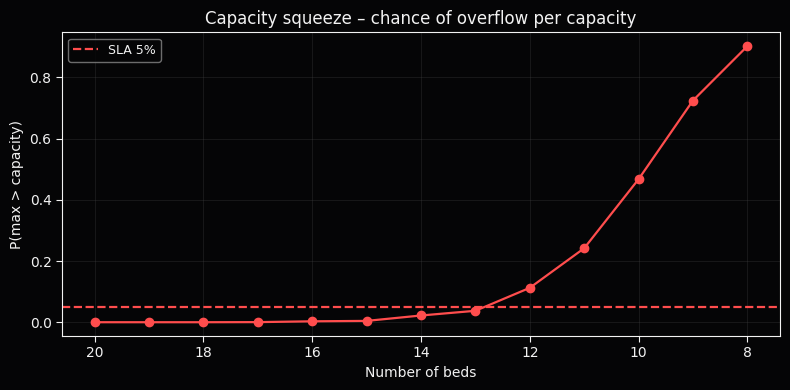

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(df_curve_ml["beds"], df_curve_ml["P(max>100%)"], marker="o")
plt.axhline(0.05, linestyle="--", label="SLA 5%")
plt.gca().invert_xaxis()
plt.xlabel("Number of beds")
plt.ylabel("P(max > capacity)")
plt.title("Capacity squeeze – chance of overflow per capacity")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
from digital_twin.core.des_engine import run_single_ward_des
from digital_twin.hospital.data_prep import los_values

from digital_twin.hospital.config_loader import load_hospital_config
cfg = load_hospital_config("digital_twin/hospital/configs/hospital_1.yml")
config = cfg.simulation

los = los_values(patients, config["service_default"])
def los_sampler(n: int) -> np.ndarray:
    draw = rng.choice(los, size=n, replace=True)
    return np.clip(draw, 0.5, None)

bed_grid = [8, 10, 12, 14, 16]

dfs = []
for b in bed_grid:
    df_b = run_single_ward_des(
        cfg=cfg,
        ward_id="SEH",
        mu_series=mu_fc,
        override_capacity=b,
        processtime_sampler=los_sampler,
        warmup_days=14,
        n_rep=200,
    )
    dfs.append(df_b)

df_des = pd.concat(dfs, ignore_index=True)

df_des.groupby("beds")[["mean_wait","p95_wait","mean_occupancy","p95_occupancy","days_over_95pct"]].mean()


,mean_wait,p95_wait,mean_occupancy,p95_occupancy,days_over_95pct
beds,,,,,
8,0.226844,1.470657,3.596476,7.69700,20.460
10,0.037750,0.230245,3.563214,8.07825,4.475
12,0.006052,0.030287,3.601714,8.04375,0.745
14,0.000283,0.000000,3.589048,8.14250,0.110
16,0.000000,0.000000,3.589262,8.12225,0.000


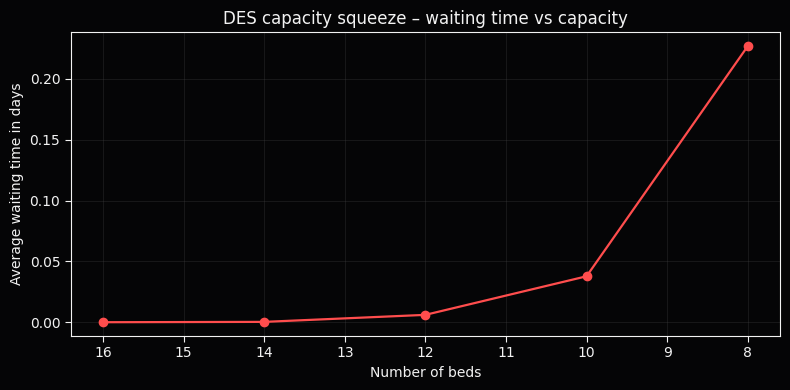

In [15]:
import matplotlib.pyplot as plt

grp = df_des.groupby("beds")["mean_wait"].mean()

plt.figure(figsize=(8,4))
plt.plot(grp.index, grp.values, marker="o")
plt.xlabel("Number of beds")
plt.ylabel("Average waiting time in days")
plt.title("DES capacity squeeze – waiting time vs capacity")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()


# **Results**

Even with minimal features, the model captures modest short-term trends. While performance is not sufficient for operational deployment, the PoC confirms that combining **simulation** with **predictive signals** is a viable direction—especially when enhanced with richer data sources (e.g., staffing, scheduling, or external demand drivers).


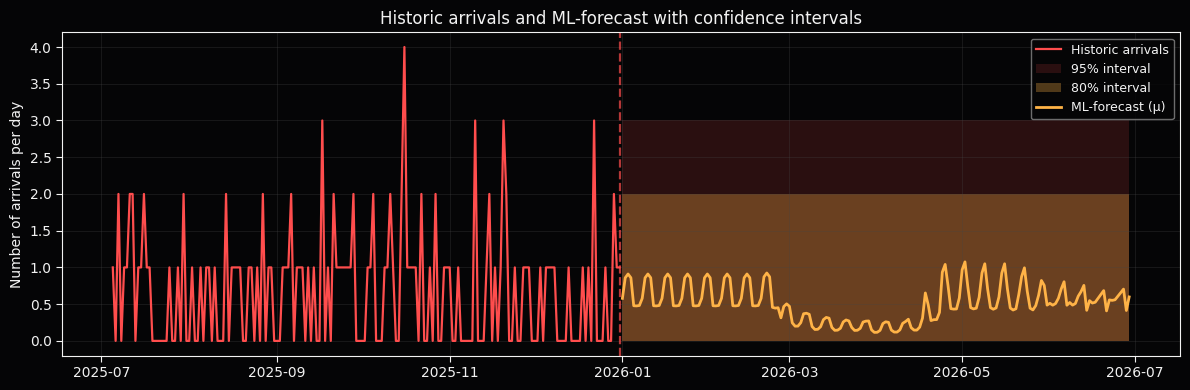

In [16]:

import numpy as np
import matplotlib.pyplot as plt

from digital_twin.core.arrivals_ml import sample_arrivals_from_mu 


hist_window = 180
hist = arr.sort_index().tail(hist_window)

n_samples = 500
arr = arr_df["arrivals"]
arrival_sampler_hist = make_arrival_sampler(arr)
samples_fc = arrival_sampler_hist(size=n_samples)  # shape: (n_samples, n_days)

q10 = np.percentile(samples_fc, 10, axis=0)
q90 = np.percentile(samples_fc, 90, axis=0)
q025 = np.percentile(samples_fc, 2.5, axis=0)
q975 = np.percentile(samples_fc, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(12,4))

# history
ax.plot(hist.index, hist.values, label="Historic arrivals")

# forecast 95%
ax.fill_between(mu_fc.index, q025, q975, alpha=0.15, label="95% interval")

# forecast 80%
ax.fill_between(mu_fc.index, q10, q90, alpha=0.3, label="80% interval")

# forecast-mean
ax.plot(mu_fc.index, mu_fc.values, label="ML-forecast (μ)", linewidth=2)

# line between past and present
ax.axvline(hist.index.max(), linestyle="--", alpha=0.7)

ax.set_title("Historic arrivals and ML-forecast with confidence intervals")
ax.set_ylabel("Number of arrivals per day")
ax.legend()
fig.tight_layout()
plt.show()


In [17]:
rng = np.random.default_rng(seed=42)

def sample_los(size):
    """Sample lengths of stay (in days) from empirical distribution."""
    return rng.choice(los, size=size, replace=True)

def sample_daily_arrivals(size):
    """Sample aantal arrivals per day from empiric daily arrivals."""
    return rng.choice(arr, size=size, replace=True)

    
def simulate_single_trajectory(days=180, arrival_scale=1.0, los_scale=1.0):
    los_remaining = np.array([], dtype=float)
    occupancies = []
    
    for day in range(days):
        if los_remaining.size > 0:
            los_remaining -= 1.0
            los_remaining = los_remaining[los_remaining > 0]
        
        n_new = int(round(sample_daily_arrivals(1)[0] * arrival_scale))
        if n_new > 0:
            new_los = sample_los(n_new) * los_scale
            new_los = np.clip(new_los, 0.5, None)
            los_remaining = np.concatenate([los_remaining, new_los])
        
        occupancies.append(los_remaining.size)
    
    return np.array(occupancies)

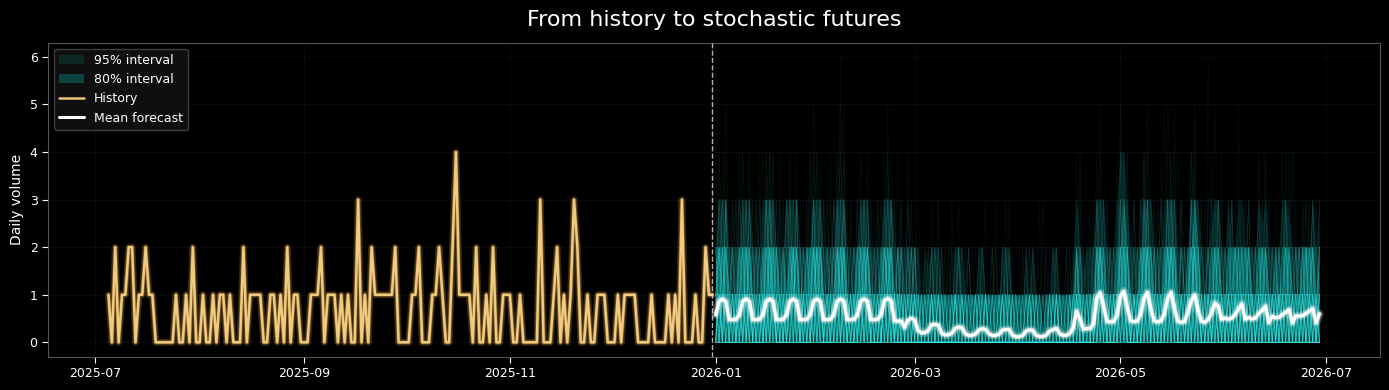

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from digital_twin.core.arrivals_ml import sample_arrivals_from_mu


hist_window = 180
hist = arr.sort_index().tail(hist_window)

n_samples = 500
samples_fc = sample_arrivals_from_mu(mu_fc, n_samples=n_samples)  # (n_samples, n_days)

q10  = np.percentile(samples_fc, 10,  axis=0)
q90  = np.percentile(samples_fc, 90,  axis=0)
q025 = np.percentile(samples_fc, 2.5, axis=0)
q975 = np.percentile(samples_fc, 97.5, axis=0)

# === cinematic plot ===
fig, ax = plt.subplots(figsize=(14, 4), facecolor="black")
ax.set_facecolor("black")

ax.grid(color="white", alpha=0.06, linewidth=0.5)

t_hist = hist.index
y_hist = hist.values
t_fc   = mu_fc.index
y_mu   = mu_fc.values

n_show = min(150, n_samples)
for i in range(n_show):
    ax.plot(
        t_fc,
        samples_fc[i],
        color="#66faff",
        alpha=0.04,
        linewidth=0.7,
        zorder=1,
    )

# --- confidence intervals ---
ax.fill_between(
    t_fc, q025, q975,
    color="#00fff0",
    alpha=0.10,
    linewidth=0.0,
    zorder=2,
    label="95% interval",
)
ax.fill_between(
    t_fc, q10, q90,
    color="#00fff0",
    alpha=0.22,
    linewidth=0.0,
    zorder=3,
    label="80% interval",
)

# --- history ---
for lw, alpha in [(5, 0.20), (3, 0.35)]:
    ax.plot(
        t_hist,
        y_hist,
        color="#f5b04c",
        linewidth=lw,
        alpha=alpha,
        solid_capstyle="round",
        zorder=4,
    )
ax.plot(
    t_hist,
    y_hist,
    color="#ffd98a",
    linewidth=1.8,
    alpha=0.9,
    solid_capstyle="round",
    label="History",
    zorder=5,
)

# --- mean-forecast ---
for lw, alpha in [(6, 0.25), (3.5, 0.45)]:
    ax.plot(
        t_fc,
        y_mu,
        color="#ffffff",
        linewidth=lw,
        alpha=alpha,
        solid_capstyle="round",
        zorder=6,
    )
ax.plot(
    t_fc,
    y_mu,
    color="#ffffff",
    linewidth=2.2,
    alpha=1.0,
    solid_capstyle="round",
    label="Mean forecast",
    zorder=7,
)

# --- line between past and present ---
cutoff = t_hist.max()
ax.axvline(
    cutoff,
    color="white",
    linestyle="--",
    linewidth=1.0,
    alpha=0.7,
    zorder=8,
)


ax.set_title(
    "From history to stochastic futures",
    color="white",
    fontsize=16,
    pad=12,
)
ax.set_ylabel("Daily volume", color="white")
ax.tick_params(colors="white", labelsize=9)

for spine in ax.spines.values():
    spine.set_color("#555555")

legend = ax.legend(
    facecolor="#111111",
    edgecolor="#444444",
    framealpha=0.9,
    fontsize=9,
    loc="upper left",
)
for text in legend.get_texts():
    text.set_color("white")

fig.tight_layout()
plt.show()


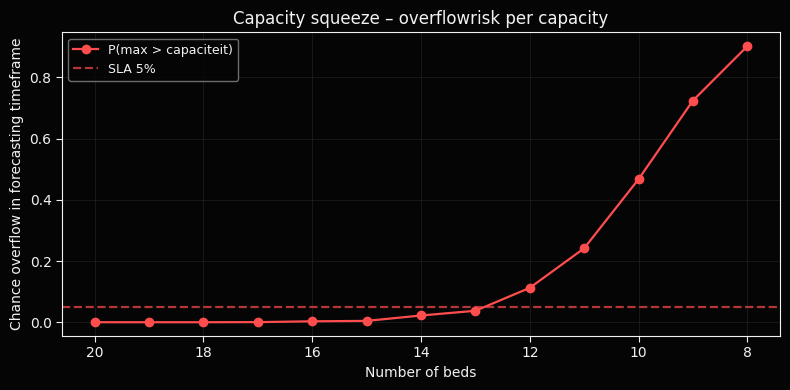

In [19]:
import matplotlib.pyplot as plt

df_curve_ml_sorted = df_curve_ml.sort_values("beds")

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(df_curve_ml_sorted["beds"], df_curve_ml_sorted["P(max>100%)"], marker="o", label="P(max > capaciteit)")

# 5%-line
sla = 0.05
ax.axhline(sla, linestyle="--", alpha=0.7, label="SLA 5%")

ax.set_xlabel("Number of beds")
ax.set_ylabel("Chance overflow in forecasting timeframe")
ax.set_title("Capacity squeeze – overflowrisk per capacity")


ax.invert_xaxis()
ax.legend()
fig.tight_layout()
plt.show()


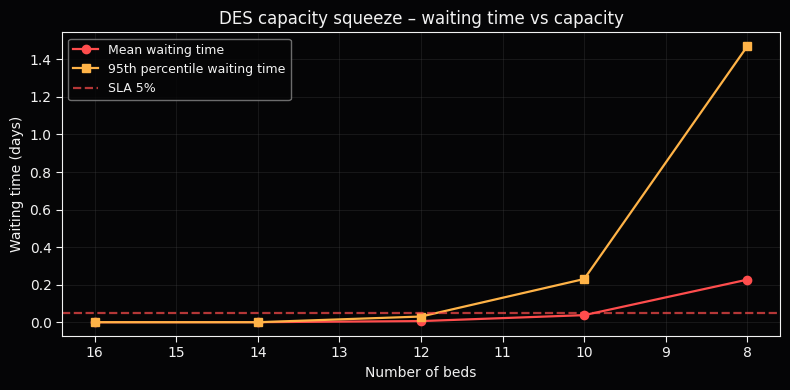

In [20]:
import matplotlib.pyplot as plt

des_summary = (
    df_des
    .groupby("beds")[["mean_wait", "p95_wait"]]
    .mean()
    .sort_index()
)

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(des_summary.index, des_summary["mean_wait"], marker="o", label="Mean waiting time")
ax.plot(des_summary.index, des_summary["p95_wait"], marker="s", label="95th percentile waiting time")
ax.axhline(sla, linestyle="--", alpha=0.7, label="SLA 5%")

ax.set_xlabel("Number of beds")
ax.set_ylabel("Waiting time (days)")
ax.set_title("DES capacity squeeze – waiting time vs capacity")
ax.invert_xaxis()
ax.legend()
fig.tight_layout()
plt.show()


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from digital_twin.core.mc_simulator import simulate_from_mu_series

def capacity_profile_percentiles(mu_series, bed_values, n_runs, los_sampler, rng=None):
    """
    For every capacity:
      - simulate n_runs
      - Take max_occupancy of all n_runs
      - Take p50, p80, p95, p99 of those maxima
    Returns DataFrame with index=beds, columns=['p50','p80','p95','p99'].
    """
    rng = rng or np.random.default_rng(42)
    rows = []
    for b in bed_values:
        max_occ, _ = simulate_from_mu_series(
            mu_series=mu_series,
            n_runs=n_runs,
            beds=int(b),
            processtime_sampler=los_sampler,
            rng=rng,
        )
        rows.append({
            "beds": int(b),
            "p50": float(np.percentile(max_occ, 50)),
            "p80": float(np.percentile(max_occ, 80)),
            "p95": float(np.percentile(max_occ, 95)),
            "p99": float(np.percentile(max_occ, 99)),
        })
    df = pd.DataFrame(rows).set_index("beds").sort_index()
    return df

bed_grid = range(8, 21)
df_cap_prof = capacity_profile_percentiles(mu_fc, bed_grid, n_runs=2000, los_sampler=los_sampler)

df_cap_prof


,p50,p80,p95,p99
beds,,,,
8,10.0,12.0,13.0,15.0
9,10.0,12.0,13.0,15.0
10,10.0,12.0,13.0,15.0
11,10.0,12.0,13.0,15.0
12,10.0,12.0,13.0,15.0
13,10.0,12.0,13.0,15.0
14,10.0,12.0,13.0,15.0
15,10.0,12.0,13.0,15.0
16,10.0,12.0,13.0,15.0


In [22]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

kaizar_heat = LinearSegmentedColormap.from_list(
    "kaizar_heat",
    [
        "#05051f",
        "#29134a",
        "#1f3b70",
        "#2d6a4f",
        "#ffb347",
        "#ff4d4d",
    ]
)


mpl.colormaps.register(kaizar_heat)

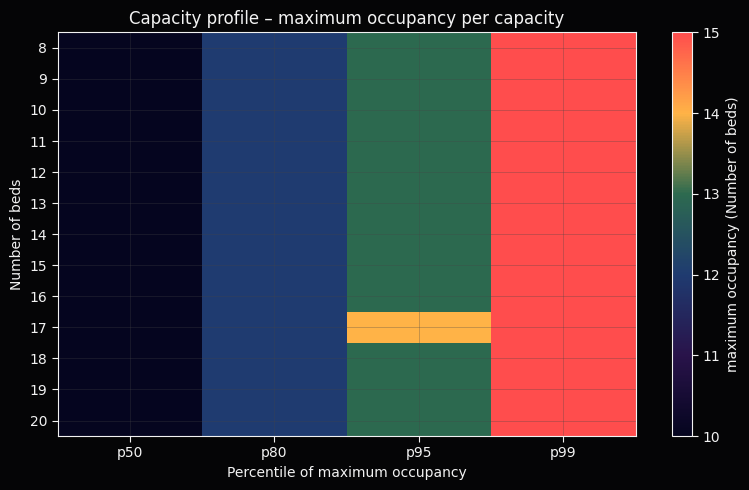

In [23]:
fig, ax = plt.subplots(figsize=(8,5))


beds_sorted = df_cap_prof.index.values
percentile_labels = ["p50", "p80", "p95", "p99"]
mat = df_cap_prof[percentile_labels].values  # shape: (n_beds, 4)

im = ax.imshow(mat, cmap="kaizar_heat", aspect="auto")

ax.set_yticks(np.arange(len(beds_sorted)))
ax.set_yticklabels(beds_sorted)
ax.set_xticks(np.arange(len(percentile_labels)))
ax.set_xticklabels(percentile_labels)

ax.set_xlabel("Percentile of maximum occupancy")
ax.set_ylabel("Number of beds")
ax.set_title("Capacity profile – maximum occupancy per capacity")

fig.colorbar(im, ax=ax, label="maximum occupancy (Number of beds)")
fig.tight_layout()
plt.show()


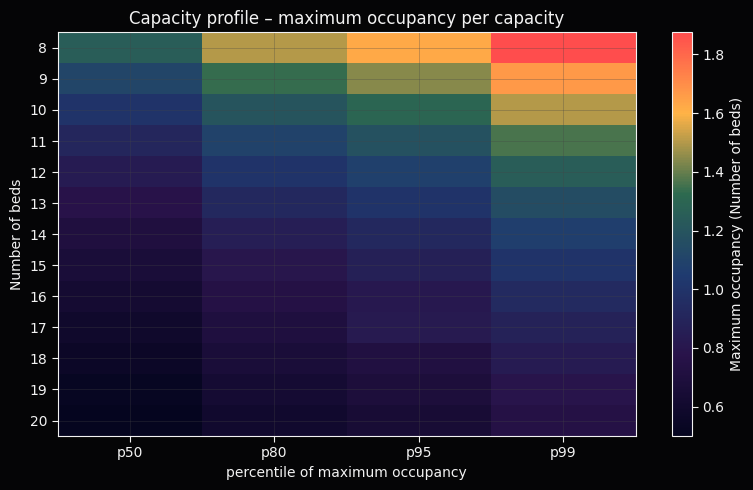

In [24]:
df_cap_prof_ratio = df_cap_prof.div(df_cap_prof.index, axis=0)

fig, ax = plt.subplots(figsize=(8,5))


beds_sorted = df_cap_prof_ratio.index.values
percentile_labels = ["p50", "p80", "p95", "p99"]
mat = df_cap_prof_ratio[percentile_labels].values  # shape: (n_beds, 4)

im = ax.imshow(mat, cmap="kaizar_heat",aspect="auto")

ax.set_yticks(np.arange(len(beds_sorted)))
ax.set_yticklabels(beds_sorted)
ax.set_xticks(np.arange(len(percentile_labels)))
ax.set_xticklabels(percentile_labels)

ax.set_xlabel("percentile of maximum occupancy")
ax.set_ylabel("Number of beds")
ax.set_title("Capacity profile – maximum occupancy per capacity")

fig.colorbar(im, ax=ax, label="Maximum occupancy (Number of beds)")
fig.tight_layout()
plt.show()


# **3. To the Full Version**

The public edition stops here. The full version extends this proof-of-concept with:

- enriched temporal features,
- multi-horizon forecasting,
- integration with the discrete-event simulation engine,
- and domain-specific scenario logic.

These components remain proprietary and are not included in this repository.
